# 3097S Milestone 1: Sonar chirp pulse simulation and processing#
## Part 1#

This report is split into two components. The first componment dealt with a similiar scenario to that of the actual project. The second component dealt with adapting the tasks in part one to that which was relevant the design compenent. This was done to familiarise with techniques in sonar simulation and processing.

### Step 1
In order to simulate the sonar chirp pulse a chirp pulse was simulated using the rect function. This function had a Pulse length of 5ms, a bandwidth of 4kHz and a centre frequency of 10kHz.

In [116]:
#STEP 1: Chirp pulse creation

c = 343;  # Speed of sound in air in m/s
fs = 44100; # This is the sample rate of the sonar.
dt = 1/fs; # This is the sample spacing
r_max = 4; # Maximum range in metres to which to simulate.
t_max = 2*r_max/c; # Time delay to max range

# Create an array containing the time values of the samples
t = collect(0:dt:t_max); # t=0:dt:t_max defines a “range”.
# Create an array containing the range values of the samples
r = c*t/2;
# NOW create the chirp pulse, shifted by an amount td, to start at
# some time td-T/2>0.
f0 = 10000; # Centre frequency is 10 kHz
B = 4000; # Chirp bandwidth
T = 5E-3; # Chirp pulse length
K = B/T; # Chirp rate
# Define a simple a rect() function which returns for -0.5<=t<=0.5 or 0.
# The function will work if t is an array of values.
rect(t) = (abs.(t) .<= 0.5)*1.0
# rect(t/T) spans the interval [-T/2,T/2]
# We must therefore delay the chirp pulse so that it starts after t=0.
# Shift the chirp pulse by 0.6T units to the right, so that it starts at
0.1*T
td = 0.6*T; # Chirp delay
# Note: one can use the macro “@.” to avoid having to put “.” for arrays:
# @. v_tx = cos( 2*pi*(f0*(t-td) + 0.5*K*(t-td).^2) ).*rect((t-td)/T);
v_tx = cos.( 2*pi*(f0*(t .- td) + 0.5*K*(t .- td).^2) ) .* rect.((t .-td)/T);

The chirp signal was represnted in both the time and frequecny domains. These plots were zoomed into and examined using the "pygui(true)" command which launched windows of the plots. The frequency plots were made using the the FFTW library within Julia.

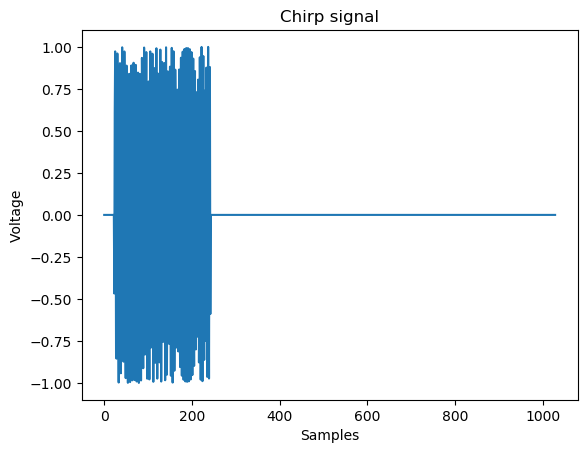

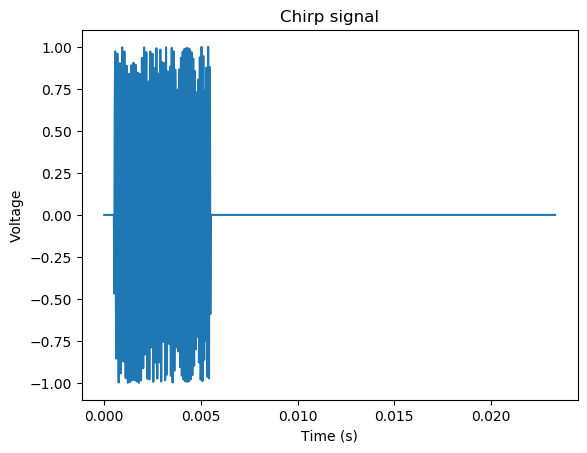

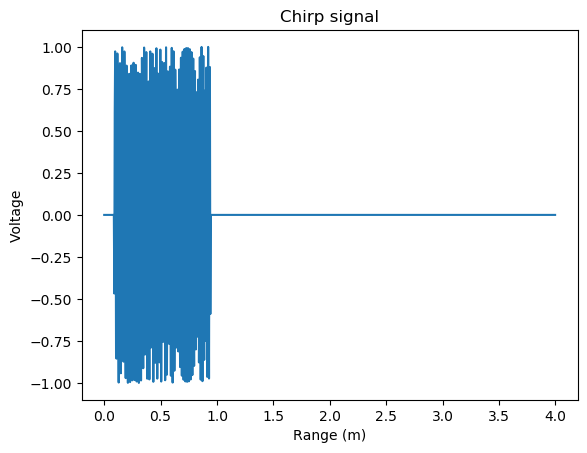

In [117]:
using PyPlot; pygui(false) # import plot library
# If not installed, add the package via: using Pkg; Pkg.add("PyPlot");
figure() # Create a new figure
plot(v_tx) # Basic plot, axis labeled in samples
title("Chirp signal")
xlabel("Samples");
ylabel("Voltage");

figure() # Create a new figure
plot(t,v_tx) # Put time on x-axis
title("Chirp signal")
xlabel("Time (s)");
ylabel("Voltage");

figure() # Create a new figure
plot(r,v_tx) # Put range on x-axis
title("Chirp signal")
xlabel("Range (m)");
ylabel("Voltage");


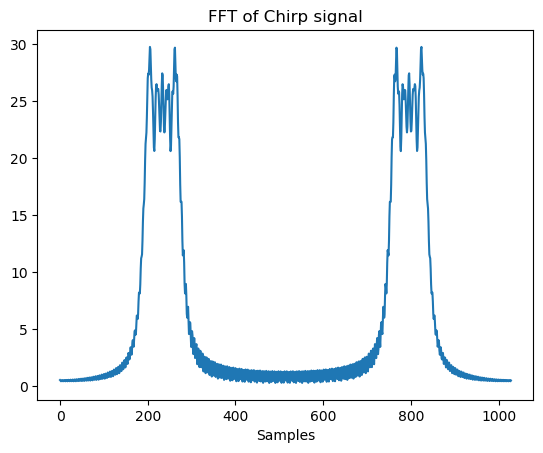

In [118]:
using FFTW # If not installed do: using Pkg; Pkg.add("FFTW");

V_TX = fft(v_tx); 
figure()
plot( abs.(V_TX) )
title("FFT of Chirp signal");
xlabel("Samples");

A discrete Fourier transform plot was also created. The right hand side represented the negative components.

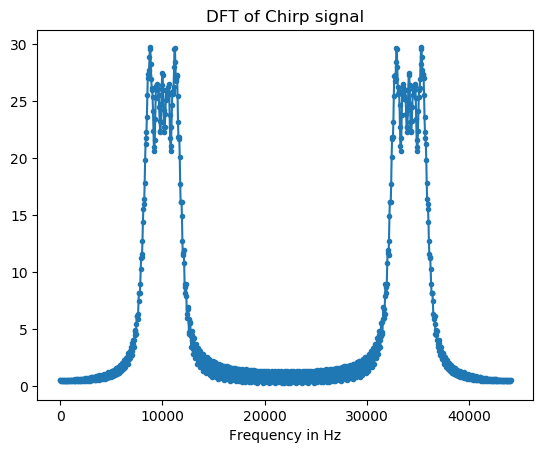

In [119]:
#LABEL frequency axis
N = length(t);
Δf = 1/(N*dt) # spacing in frequency domain
#create array of freq values stored in f_axis. First element maps to 0Hz
f_axis = (0:N-1)*Δf;
figure();
plot(f_axis, abs.(V_TX),".-");
title("DFT of Chirp signal");
xlabel("Frequency in Hz");

### Step 2
Two targets were simulated. The first was at a distance of 2.33m (birthday in February). The second was taking at an arbitrary distance using October in the R1 equation. From this time and frequency domain plots were created. First for the first target and then for both targets added superimposed.

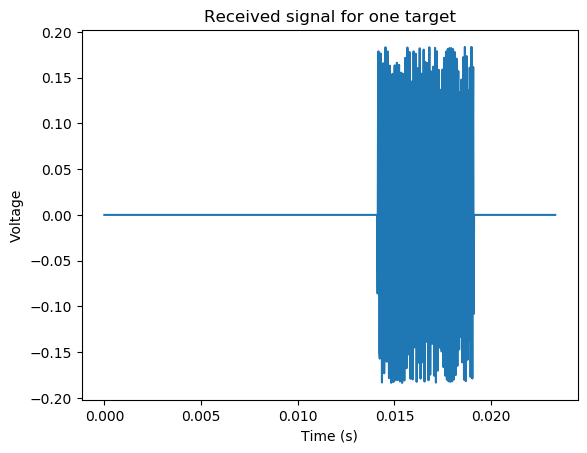

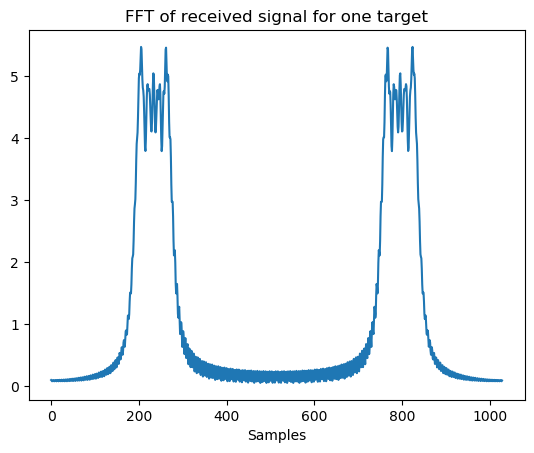

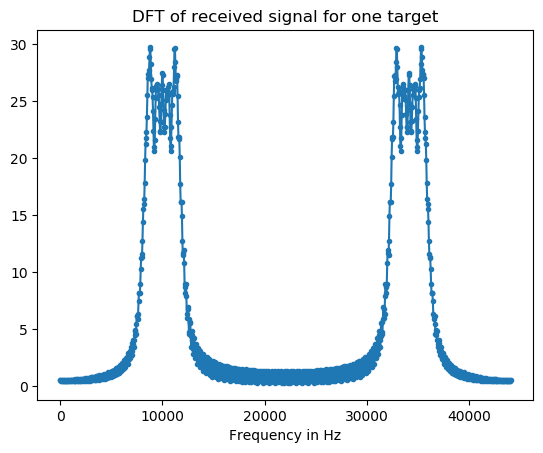

In [120]:
#STEP 2: Point target simulation

R1 = 1.5 + (12-2)/12 # 2.33m - range to target.
td1 = 2*R1/c; # two way delay to target.
A1 = 1/R1^2; # echo voltage signal proportional to 1/R^2
v_rx = A1*cos.( 2*pi*(f0*(t.-td.-td1) + 0.5*K*(t.-td.-td1).^2) ) .* rect((t.-
td.-td1)/T); 

V_RX = fft(v_rx);

figure() # Create a new figure
plot(t,v_rx) # Put time on x-axis
title("Received signal for one target")
xlabel("Time (s)");
ylabel("Voltage");

figure() # Create a new figure
plot(abs.(V_RX) )
title("FFT of received signal for one target");
xlabel("Samples");

figure();
plot(f_axis, abs.(V_TX),".-");
title("DFT of received signal for one target");
xlabel("Frequency in Hz");

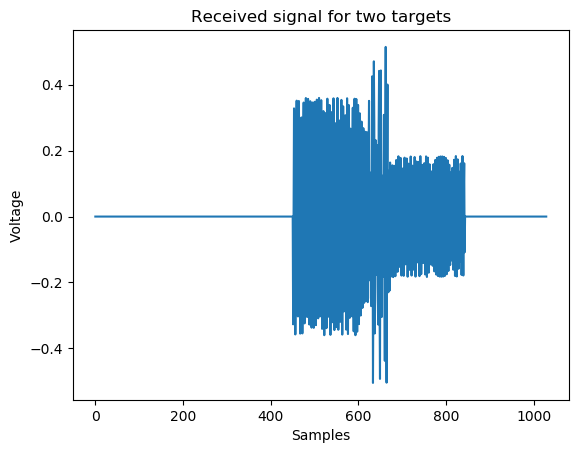

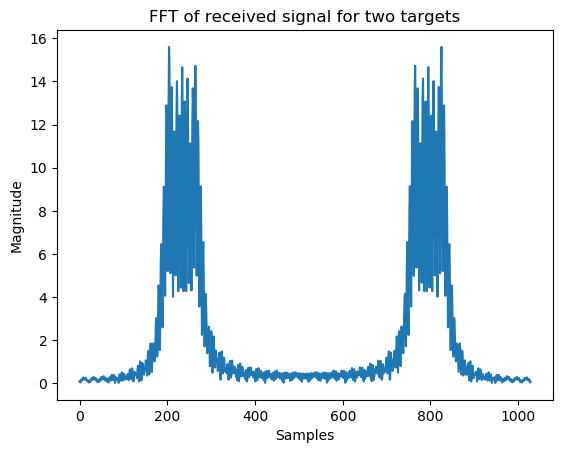

In [121]:
#second target
R2 =  1.5 + (12-10)/12# 1.67m - range to target.
td2 = 2*R2/c; # two way delay to target.
A2 = 1/R2^2; # echo voltage signal proportional to 1/R^2
v_rx = A1*cos.(2*pi*(f0*(t.-td.-td1) + 0.5*K*(t.-td.-td1).^2) ) .* rect((t.-
td.-td1)/T) + A2*cos.(2*pi*(f0*(t.-td.-td2) + 0.5*K*(t.-td.-td2).^2) ) .* rect((t.-
td.-td2)/T);
V_RX = fft(v_rx);

figure() # Create a new figure
plot(v_rx) # Put time on x-axis
title("Received signal for two targets")
xlabel("Samples");
ylabel("Voltage");

figure() # Create a new figure
plot(abs.(V_RX) )
title("FFT of received signal for two targets");
xlabel("Samples");
ylabel("Magnitude");

### Step 3

In order to maximise the signal to noise ratio the match filter method was applied. This resulted in a real signal as the imaginary signal had a neglible magnitude, smaller the 1E-14. This resulted in pulse compression.

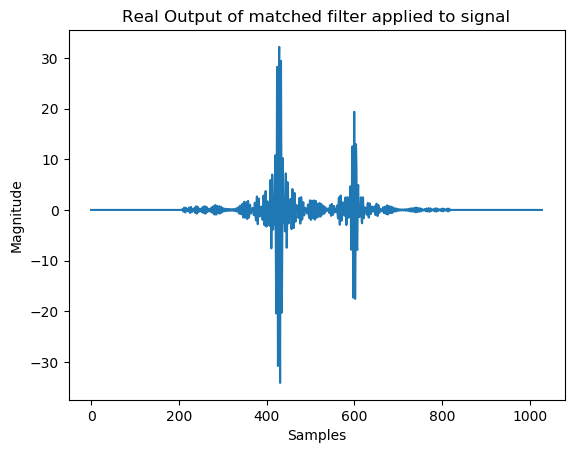

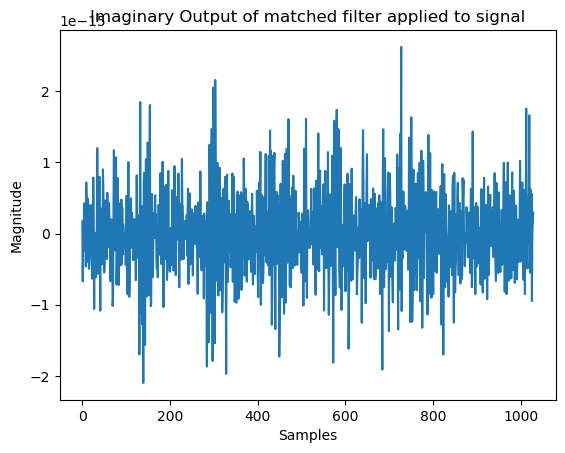

In [122]:
#STEP 3: Matched filtering

H = conj( V_TX);
V_MF = H.*V_RX;
v_mf = ifft(V_MF);

figure() # Create a new figure
plot(real(v_mf));
title("Real Output of matched filter applied to signal")
xlabel("Samples");
ylabel("Magnitude");

figure() # Create a new figure
plot(imag(v_mf));
title("Imaginary Output of matched filter applied to signal")
xlabel("Samples");
ylabel("Magnitude");

#Negligble Imaginary part <1E-14

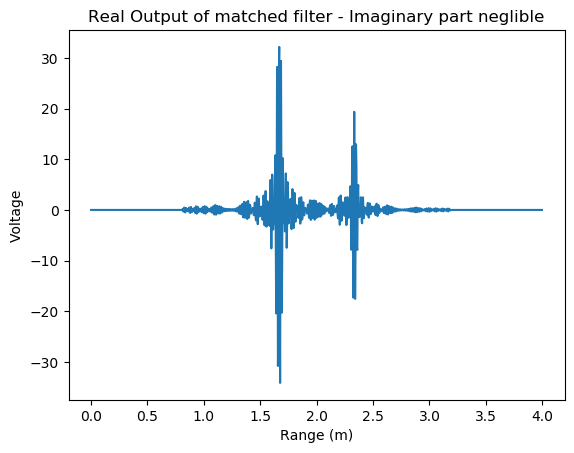

In [123]:
v_mf = real(v_mf);
figure() # Create a new figure
plot(r,v_mf) # To see the detail – zoom in to have a good look.
title("Real Output of matched filter - Imaginary part neglible")
xlabel("Range (m)");
ylabel("Voltage");


# Take note of the shape of the envelope, as well as the internal detail.
# effect of pulse compression

### Step 4

In order to form the analytic signal, the negative frequency components were removed. This was done by zeroing the second half of the array. The analytic signal was obtained from the inverse fourier transform. The magnitude and phase of the analytic signal were plotted in the time domain.

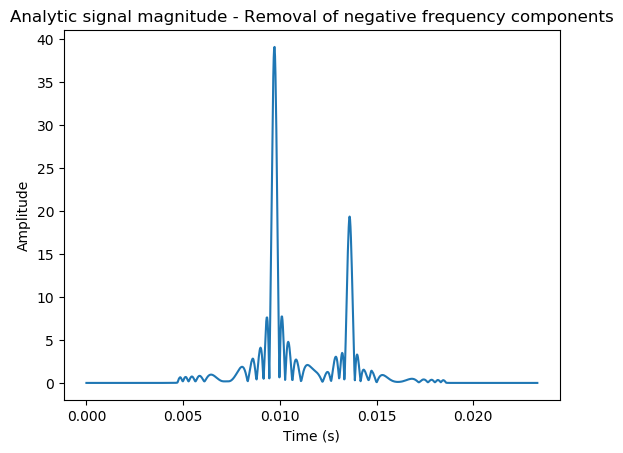

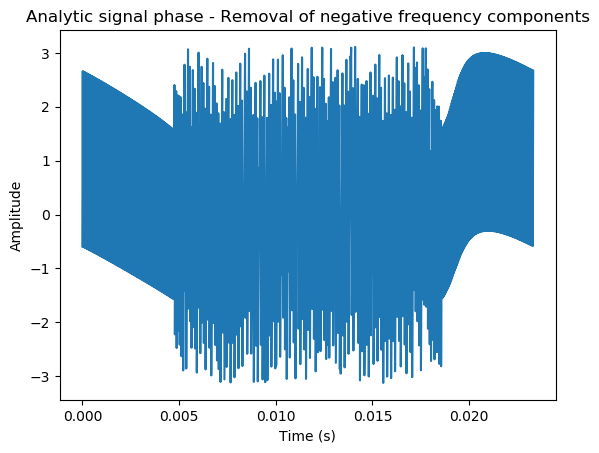

In [124]:
#STEP 4: Forming an analytic signal

V_ANAL = 2*V_MF; # make a copy and double the values
N = length(V_MF);
if mod(N,2)==0 # case N even
 neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
 neg_freq_range = Int((N+1)/2):N;
end
V_ANAL[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal = ifft(V_ANAL);

figure() # Create a new figure
plot(t,abs.(v_anal)) # To see the magnitude – zoom in to have a good look.
title("Analytic signal magnitude - Removal of negative frequency components")
xlabel("Time (s)");
ylabel("Amplitude");

figure() # Create a new figure
plot(t,angle.(v_anal))
title("Analytic signal phase - Removal of negative frequency components")
xlabel("Time (s)");
ylabel("Amplitude");

These graphs agree with the theory. The frerquency domain graphs contain conjugate symmetry which implies its a purely real signal. This has been represented in the graphs plotted above which shows a neglible imaginary component.

this implies the negative spectral components can be removed as they can be constructed from the popsitive components.

The 3dB point was at 39.2*0.707 =27.75
From this it could be seen that dt ≈ 0.00982712 - 0.00960746= 219.66E-6 s. 
The theory indicates this value sholuld be:
dt ≈ 1/B = 1/4000 = =250E-6 s      
This results in a 12% error from theory.
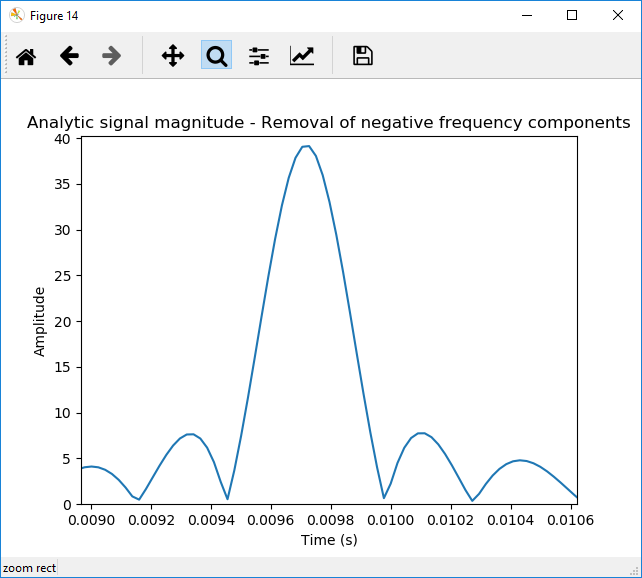


<br> In order to reduce the sidelobes a windowing technique could be used. This technique would result in reduction in the lower side lobes but a wider mainlobe.

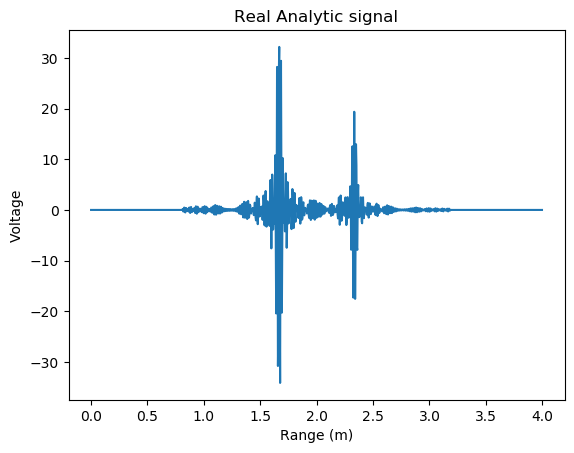

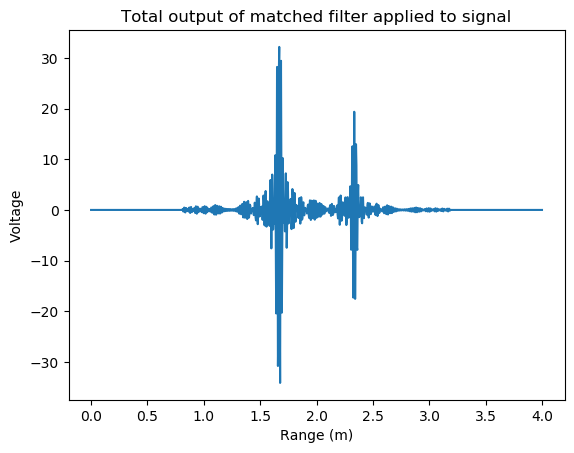

In [125]:
figure() # Create a new figure
plot(r,real(v_anal));  #compare to v_mf
title("Real Analytic signal")
xlabel("Range (m)");
ylabel("Voltage");

figure() # Create a new figure
plot(r,v_mf);
title("Total output of matched filter applied to signal")
xlabel("Range (m)");
ylabel("Voltage");

The above graphs show that v_anal is the same as v_mf.

## Step 5

This does agree with the theory. Multiplying by the exp(-j*2*pi*f0*t) causes the signal to be doubled in magnitude is also shifted to two locations, the origin and -2f0. The FFT of the baseband shows that the signal has been shifted to 0 Hz as predicted. Over the mainlobe the the phase is constant as shwon in the figure below.

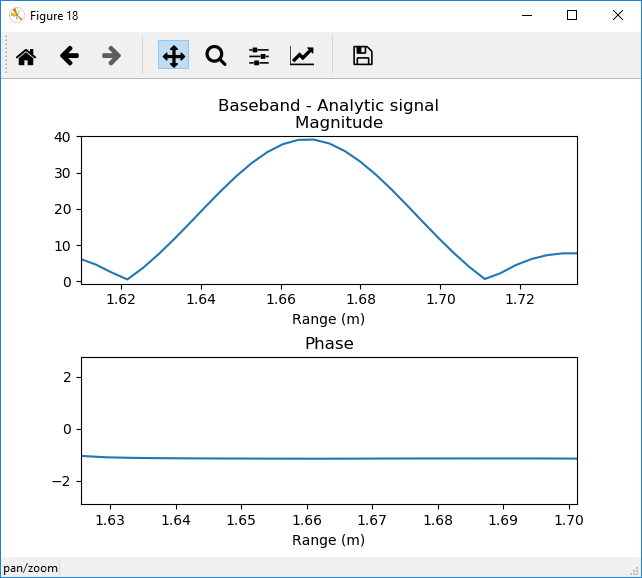

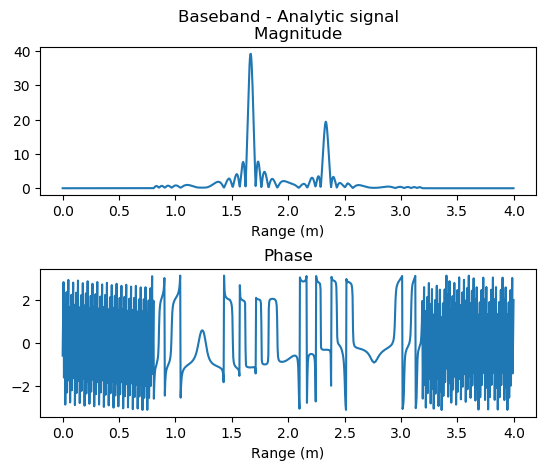

In [126]:
#STEP 5: Translating the signal to baseband

j=im; # Assign j as sqrt(-1) (“im” in julia)
v_bb = v_anal.*exp.(-j*2*pi*f0*t);

fig = figure() # Create a new figure

subplot(2,1,1)
plot(r,abs.(v_bb))
title("Baseband - Analytic signal
    Magnitude")
xlabel("Range (m)");
fig.subplots_adjust(hspace=.5)
subplot(2,1,2)
plot(r,angle.(v_bb))
title("
Phase")
xlabel("Range (m)");


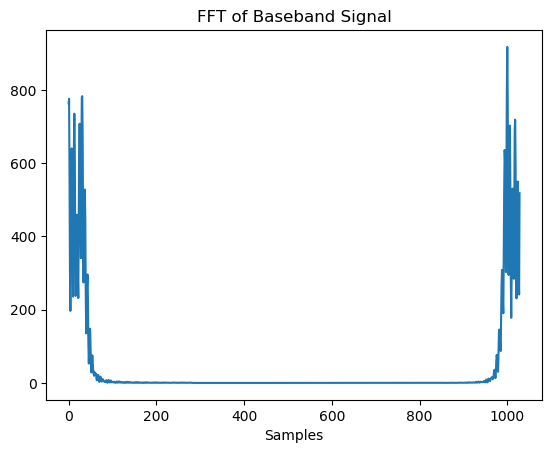

In [127]:
V_BB = fft(v_bb); 
figure() # Create a new figure
plot(abs.(V_BB))
title("FFT of Baseband Signal");
xlabel("Samples");

### Step 6
Noise was added to the system and the PSD of the noise was found. The previous steps were also completed with the noise and the match filter was found output a similiar result. This was expected as the match filter outputs the peak signal to noise ratio. 

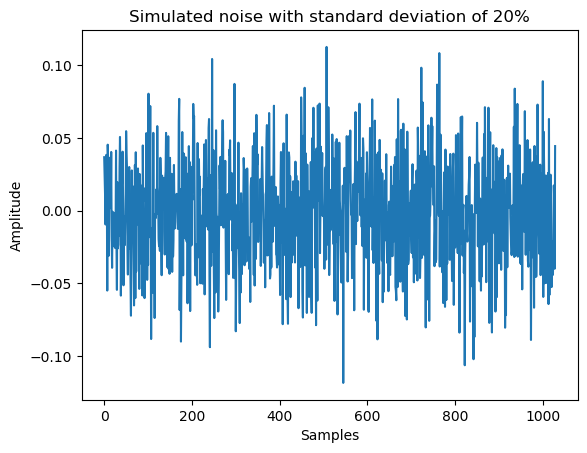

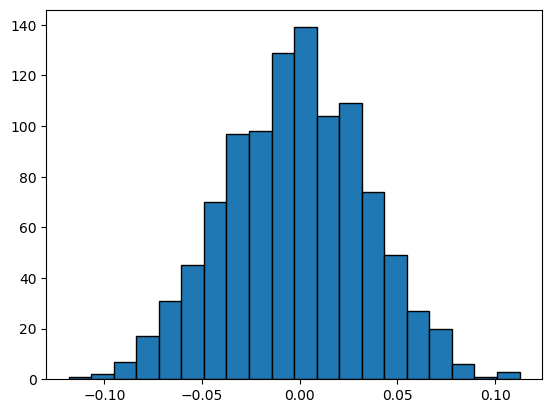

Calculated std dev = 0.036318872046987354


In [128]:
#STEP 6: Adding noise to the simulation

sigma = 0.2 * A1;
noise_signal = sigma * randn(N);
figure() # Create a new figure
plot(noise_signal)
title("Simulated noise with standard deviation of 20%");
xlabel("Samples");
ylabel("Amplitude");

figure() # Create a new figure
nbins=20
hist(noise_signal,nbins,edgecolor = "black")
using Statistics # import basic stats functions
println("Calculated std dev = ", std(noise_signal))



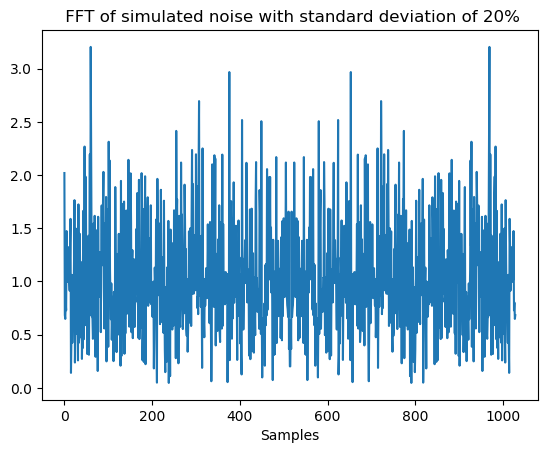

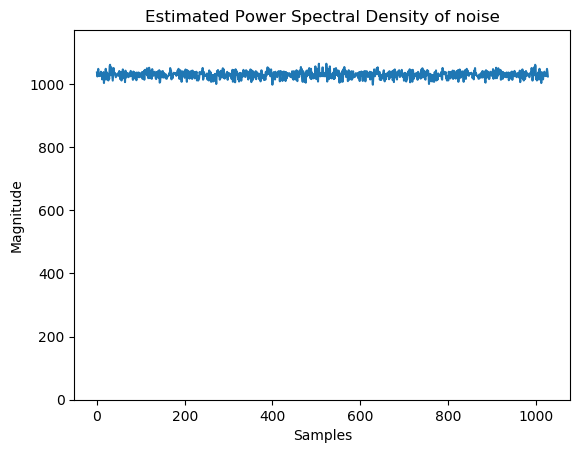

(0.0, 1170.9484182461692)

In [129]:
figure() # Create a new figure
NS = fft(noise_signal);
plot(abs.(NS))
title(" FFT of simulated noise with standard deviation of 20%");
xlabel("Samples");

#PSD 

N_ave = 10000; # Try different values of Nave 10, 100, 1000 ...
PSD_sum = zeros(N);
for n=1:N_ave;
global PSD_sum = PSD_sum .+ ( abs.(fft( randn(N) )) ).^2;
end
PSD_estimated = PSD_sum/N_ave;
figure();
plot(PSD_estimated);
title("Estimated Power Spectral Density of noise");
xlabel("Samples");
ylabel("Magnitude");
ylim([0,1.1*maximum(PSD_estimated)])


From the power spectral desnity graph above it can be seen that the noise is indeed white noise. This noise is constant over the entrie duration however, is not bandlimited. This is due the simulation not represnting the bandlimiting of the receiver.

### Step 7
In order to compensate for the inverse square relationship between the recived signal and the distance, range compensation was performed. This was done using two rect functions at each of the targets locations and multiplying by a factor of R^2. The figures below show that this compensation corrected the smaller peak of the target located further away.

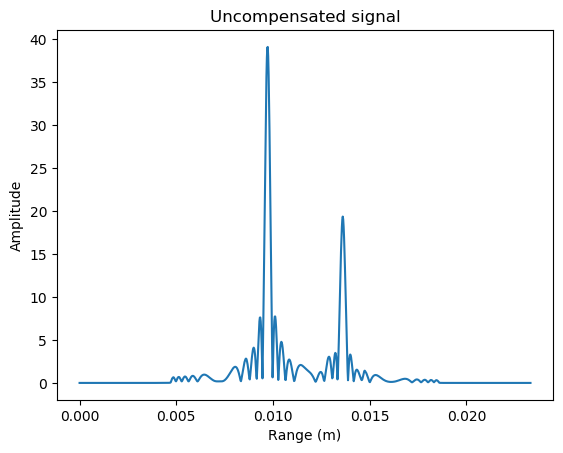

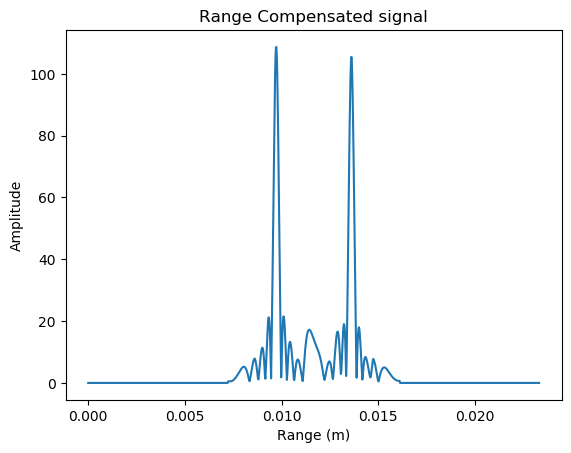

In [130]:
#Part 7

# Define a simple a rect() function which returns for -0.25<=t<=0.25 or 0.
# The function will work if t is an array of values.
rect2(t) = (abs.(t) .<= 0.25)*1.0
R1_func = R1^2 
R2_func = R2^2
v_rc = v_bb.* rect.((t.-td1)/T)*R1_func .+ v_bb.* rect.((t .-td2)/T)*R2_func;

figure() # Create a new figure
plot(t,real(abs.(v_bb)));    
title("Uncompensated signal")
xlabel("Range (m)");
ylabel("Amplitude");

figure() # Create a new figure
plot(t,real(abs.(v_rc)));    
title("Range Compensated signal")
xlabel("Range (m)");
ylabel("Amplitude");

## Step 8

The zero padding technique was performed on the compensated signal in order to smooth out the waveforms and allow for closer spaced samples. The sample spacing for the time and range had to be recalculated.

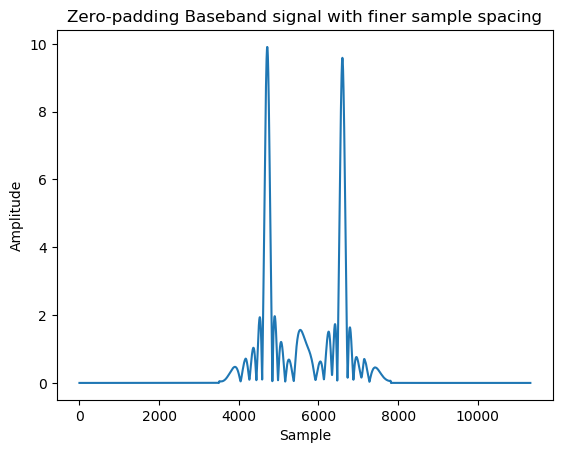

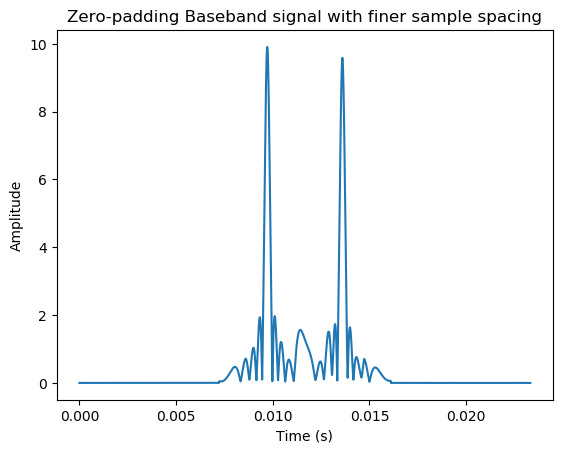

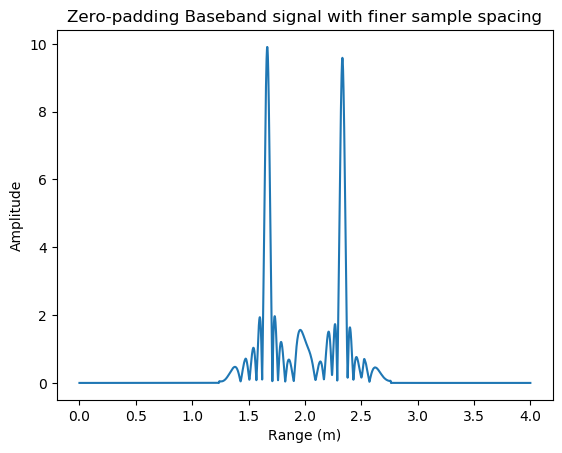

In [131]:
#Part 8
Empty  = zeros(10*N)
p = floor(Int32, N/2)
V_RC_Padded = fft(v_rc)
temp = vcat(V_RC_Padded[1:p-1], Empty)
X = vcat(temp, V_RC_Padded[p:end])
x = ifft(X);
time_new = collect(0:dt/11.004:t_max);
range_new = c*time_new/2;

figure()
plot(real(abs.(x)));
title("Zero-padding Baseband signal with finer sample spacing")
xlabel("Sample");
ylabel("Amplitude");

using PyPlot;
figure()
plot(time_new,real(abs.(x)));
title("Zero-padding Baseband signal with finer sample spacing")
xlabel("Time (s)");
ylabel("Amplitude");


figure()
plot(range_new,real(abs.(x)));
title("Zero-padding Baseband signal with finer sample spacing")
xlabel("Range (m)");
ylabel("Amplitude");